# Growing Decision Trees via ID3/C4.5 & Greedy Learning 


A from-scratch implementation of a growing decision trees ML algorithm for quick classification. We use entropy / 'information gain' as the metric for generating the decision rules.


### Example

An application of growing decision trees on a sample dataset. I've included some sample datasets to test the implementation on.

In [71]:
import pandas as pd

### Entering data as columns - pandas reads them as tuples though so they will have to be transformed
credit_ranking_data = ["Excellent","Excellent","Excellent","Excellent","Good","Good","Good","Good","Fair","Fair","Fair","Fair"]
age_data = ["< 30","< 30","> 60","> 60","30 - 60","30 - 60","< 30","< 30","> 60","30 - 60","< 30","< 30"]
gender_data = ["M","F","M","F","M","F","M","F","M","F","M","F"]
year_income_data = ["60k - 100k","> 100k","> 100k","60k - 100k","< 60k","60k - 100k","> 100k","60k - 100k","> 100k","60k - 100k","60k - 100k","< 60k"]
counts_data = [16,4,4,16,5,15,5,15,2,2,18,18]

ex_df = pd.DataFrame.from_records(data = [ credit_ranking_data, age_data, gender_data, year_income_data, counts_data])
### Transpose to put in proper form
ex_df = ex_df.T
### Add column labels
cols = ["credit-ranking","age","gender","year-income","count"]
ex_df.columns = cols
(ex_df) # just checking

,credit-ranking,age,gender,year-income,count
0,Excellent,< 30,M,60k - 100k,16
1,Excellent,< 30,F,> 100k,4
2,Excellent,> 60,M,> 100k,4
3,Excellent,> 60,F,60k - 100k,16
4,Good,30 - 60,M,< 60k,5
5,Good,30 - 60,F,60k - 100k,15
6,Good,< 30,M,> 100k,5
7,Good,< 30,F,60k - 100k,15
8,Fair,> 60,M,> 100k,2
9,Fair,30 - 60,F,60k - 100k,2


The bank-dataset table above is a useful illustration of the kind of formatting the algorithm expects:

* The desired class-label column is the first column (this can be adjusted to be more flexible in the future)
* The last column is a count column (this  can be easily found by using aggregation functions on an arbitrary dataset)


In the following, I walk through construction of the information purity heuristic which we use to grow the decision tree.

## Information Purity Measures

In [72]:
import math

# term from info function I
def p_logp(p): # scope --- p is proportion from 0 to 1
    if (p < 10**(-10)) | (p > 1 - 10**(-10)) :
        return 0
    else: return (-1) * p * math.log2(p)
    

We can use the "p_logp" function to compute the statistical information entropy (physical measure) that occurs from observing a proportion $p$ of observations:

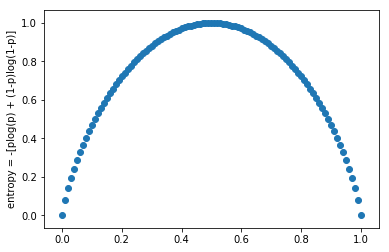

In [10]:
## EXAMPLE BASIC ENTROPY FUNCTION
granularity = 100
domain = [x/granularity for x in range(granularity+1)]
entropy_range = [ p_logp(p) + p_logp(1-p) for p in domain ]
# print(entropy_range)

import matplotlib.pyplot as plt
plt.scatter(domain,entropy_range)
plt.ylabel('entropy = -[plog(p) + (1-p)log(1-p)]')
plt.show()

In [11]:
# information measure

def info_measure(vector): ### NOTE: vector should be of counts, so all terms in it ≥ 0!! ADD CODE TO CHECK THIS LATER
    
#     if vector == [0]*len(vector):  return 0
    if sum(vector) == 0:  return 0
    return sum( [ p_logp( s/sum(vector) ) for s in vector ] )


## The Information measure $I(\mathbf{x}) = - \sum \left(\frac{x_i}{ \sum x_i } \right) \log_2 \left(\frac{x_i}{ \sum x_i } \right)$
generalizes this entropy measure to proportions drawn from higher-dimension source - ie, more than the two states corresponding to $p$ and $1-p$ (the interpretation of $\mathbf{x}$ is as a list of counts for the different states $i$). Thinking back to the basic entropy function we introduced, which came from our '$p \log_2 p$' function, if $p$ is the proportion $k/n$ then the basic entropy function was $I(\mathbf{x})$ where $\mathbf{x} = (k,n-k)$.

In general, this measures the amount of information required to classify a tuple $\mathbf{x}$ to $m$ classes (if the input $\mathbf{x}$ is an $m$-vector).

### Consider: plotting the information measure over an input of datapoints uniformly sampled from a 2D circle


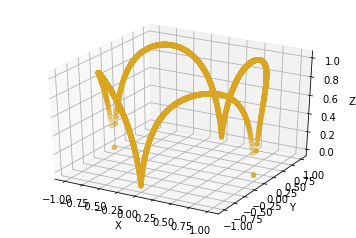

In [98]:
## EXAMPLE of the INFORMATION Measure on the input of a 2D circle

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import random

def circleplot(granularity,color=[random.random() for i in range(3)]):
    
#     granularity = 10000
    domain = [[x/granularity, (1-(x/granularity)**2)**0.5] for x in range(granularity+1)]
    entropy_range = [ info_measure(x) for x in domain ]
    # print(entropy_range)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')

    circ_points = [ x + [z] for x,z in zip(domain,entropy_range) ]

    xs = [x[0] for x in circ_points]
    ys = [x[1] for x in circ_points]
    zs = [x[2] for x in circ_points]

    ### different rectangular parametrizations of a 2d-circle
    ### we plot entropy associated with a particular configuration of points
    ax.scatter( xs,ys,zs , c=color)
    ax.scatter( xs,[-y for y in ys],zs , c=color )
    ax.scatter( [-x for x in xs],ys,zs , c=color)
    ax.scatter( [-x for x in xs],[-y for y in ys],zs , c=color)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # plt.scatter([x[0] for x in domain],entropy_range)
    # plt.scatter([x[1] for x in domain],entropy_range)
    # plt.ylabel('some numbers')
    plt.show()

circleplot(1000, 'goldenrod') # shortcut code

## Another example: 
Plot the information metric for classifying 2D points $(x,y)$ over a rectangular region $x,y \in [0,1]$ (aka $[0,1] \times [0,1]$).

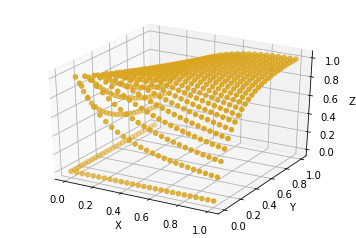

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

granularity = 25
domain = [[x/granularity, y/granularity] for x in range(granularity+1) for y in range(granularity+1)]
entropy_range = [ info_measure(x) for x in domain ]
# print(entropy_range)


fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

rect_points = [ x + [z] for x,z in zip(domain,entropy_range) ]

xs = [x[0] for x in rect_points]
ys = [x[1] for x in rect_points]
zs = [x[2] for x in rect_points]

### we plot entropy associated with a particular configuration of points
ax.scatter( xs,ys,zs , c="goldenrod")

# ### plot circle for comparison

# #####

# granularity = 100
# domain = [[x/granularity, (1-(x/granularity)**2)**0.5] for x in range(granularity+1)]
# entropy_range = [ info_measure(x) for x in domain ]

# circ_points = [ x + [z] for x,z in zip(domain,entropy_range) ]

# xs = [x[0] for x in circ_points]
# ys = [x[1] for x in circ_points]
# zs = [x[2] for x in circ_points]

# ### different rectangular parametrizations of a 2d-circle
# ### we plot entropy associated with a particular configuration of points
# ax.scatter( xs,ys,zs , c='blue')
# # ax.scatter( xs,[-y for y in ys],zs , c='blue' )
# # ax.scatter( [-x for x in xs],ys,zs , c='blue')
# # ax.scatter( [-x for x in xs],[-y for y in ys],zs , c='blue')

# #####

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plt.scatter([x[0] for x in domain],entropy_range)
# plt.scatter([x[1] for x in domain],entropy_range)
# plt.ylabel('some numbers')
plt.show()

Comparison of Plots: [TBD]

## Entropy Function

Next, we want to use the information measure to formally define an entropy function for attributes of a dataset, which is based off a weighted sum of the aggregate information measures for a given configuration of data: If the attribute $A$ with values $\{ a_1 , \dots , a_\nu \}$ partitions the dataset into subsets $\{S_1, \dots , S_\nu\}$, and $S_j$ contains $s_{ij}$ samples of a given class class $C_i$, then the entropy associated with $A$ is 

$$
E ( A ) = \sum_{j=1} ^\nu \frac{ s_{1j} + \cdots + s_{mj} }{\sum_{ij} s_{ij}} I(s_{1j} , \dots , s_{mj})
$$

Some observations –– from intuition (and by studying its defining equation) we can see that $I ( \mathbf{x} )$ tends to be maximized along the line $x_1 = x_2 = \cdots = x_m$, and hence so does the entropy function. As the interpretation of these $x_i$ was as counts for different states $i$, this means roughly speaking that we maximize entropy when the counts are similar and minimize it when they are very different. The metric we will use to grow the decision tree is information purity, or information gain, which increases as entropy decreases. So, we will maximize this when we split over branches where the counts tend to be most dissimilar. This all makes sense too, as if the counts are very dissimilar, than intuitively it is easier to predict a class label based on the counts while if they are similar, it is more difficult to decide what an appropriate class label should be.

In [99]:
# entropy cost associated with an attribute
# ASSUME: last column of input dataset is 'counts' associated with particular outcome
# ASSUME: first column is class label

### ENTROPY CORRECT - MY ORIGINAL SCRATCHWORK HAD A TYPO FOR SCALING FACTORS!

def entropy(dataset, attribute, debug_flag=False):
    label = dataset.iloc[:,0] # 1st column class label
    total_counts = sum(dataset['count'])
    total_entropy = 0
    
    for value in set(dataset[attribute]):
        if debug_flag: print(attribute, value) #debugging
        sub_data = dataset.loc[dataset[attribute] == value]
        if debug_flag: print(sub_data) #debugging
        
        label_counts = []
        for label_value in set(label):
            # pick out rows from sub data with desired label value
            sub_sub_data = sub_data.loc[sub_data.iloc[:,0] == label_value] 
            label_counts.append(sum(sub_sub_data['count']))

        if debug_flag: print(label_counts) #debugging
        if debug_flag: print(str(sum(label_counts)) + '/' + str(total_counts) + ' * I()' ) #debugging


        total_entropy += (sum(label_counts)/total_counts) * info_measure(label_counts)
    if debug_flag: print('*'*50)
    return total_entropy


In [100]:
### ENTROPY on example dataset df

print(ex_df)

print()
print('*' * 50)
print()

## Possible attributes to compute entropy on:
## Remove class label and count columns from consideration
possible_attributes = list(ex_df.columns)
possible_attributes = [possible_attributes[i] for i in range(1,len(possible_attributes)-1)] 

print((possible_attributes[0], 'entropy: ' 
       + str(entropy(ex_df, possible_attributes[0], debug_flag = False))))

   credit-ranking      age gender year-income count
0       Excellent     < 30      M  60k - 100k    16
1       Excellent     < 30      F      > 100k     4
2       Excellent     > 60      M      > 100k     4
3       Excellent     > 60      F  60k - 100k    16
4            Good  30 - 60      M       < 60k     5
5            Good  30 - 60      F  60k - 100k    15
6            Good     < 30      M      > 100k     5
7            Good     < 30      F  60k - 100k    15
8            Fair     > 60      M      > 100k     2
9            Fair  30 - 60      F  60k - 100k     2
10           Fair     < 30      M  60k - 100k    18
11           Fair     < 30      F       < 60k    18

**************************************************

('age', 'entropy: 1.1265494549903445')


In [93]:
# Define Information Gain Criteria 
# equivalent to minimizing entropy but has a nice interpretation

def info_gain(dataset, attribute, debug_flag = False):
    
    #get label counts
    label = dataset.iloc[:,0] # assume it's first column for now
    label_counts = []
    
    for label_value in set(label):
        # pick out rows from dataset with desired label value
        sub_data = dataset.loc[dataset.iloc[:,0] == label_value] 
        label_counts.append(sum(sub_data['count']))

    if debug_flag: 
        print('I(...):', label_counts) #debugging
        print('*'*50) #debugging
    
    I = info_measure(label_counts)
    return I - entropy(dataset, attribute, debug_flag)


In [94]:
info_gain(ex_df,possible_attributes[2],debug_flag=True)

I(...): [40, 40, 40]
**************************************************
year-income > 100k
  credit-ranking   age gender year-income count
1      Excellent  < 30      F      > 100k     4
2      Excellent  > 60      M      > 100k     4
6           Good  < 30      M      > 100k     5
8           Fair  > 60      M      > 100k     2
[5, 8, 2]
15/120 * I()
year-income 60k - 100k
   credit-ranking      age gender year-income count
0       Excellent     < 30      M  60k - 100k    16
3       Excellent     > 60      F  60k - 100k    16
5            Good  30 - 60      F  60k - 100k    15
7            Good     < 30      F  60k - 100k    15
9            Fair  30 - 60      F  60k - 100k     2
10           Fair     < 30      M  60k - 100k    18
[30, 32, 20]
82/120 * I()
year-income < 60k
   credit-ranking      age gender year-income count
4            Good  30 - 60      M       < 60k     5
11           Fair     < 30      F       < 60k    18
[5, 0, 18]
23/120 * I()
***********************************

0.20128468771045704

In [95]:
for attribute in possible_attributes:
    print(( attribute, 'entropy: ' + str(entropy(ex_df,attribute)), 'gain: ' + str(info_gain(ex_df,attribute)) ))
# information gained by branching on attribute A

('age', 'entropy: 1.1265494549903445', 'gain: 0.45841304573081154')
('gender', 'entropy: 1.5421864522230475', 'gain: 0.042776048498108565')
('year-income', 'entropy: 1.383677813010699', 'gain: 0.20128468771045704')


## Growing Decision Trees:

Now that we have a properly defined information gain metric for a given attribute of a dataset, we're prepared to use this to implement growing a decision tree such that it maximizes local information gain on each attribute, at each step. 

Note: We should be careful to avoid overgrowing the tree (various methods not yet implemented) as well as to look into methods to post/pre prune a tree in order to avoid over-fitting the decision tree model on the data. For example, we could implement a $k$-fold cross validation method to grow $k$ different trees on train/test folds and compare the overall accuracy obtained. 

### Printing decision trees

Here is a first pass at a growing-decision-tree algorithm, that prints generated decision rules as well as debugging info. It will automatically grow decisions to full length (use every attribute) even when not necessary. This overgrowing will be optimized for the proper algorithm.

In [191]:
#### GROWING DECISION TREES:

def print_decision_tree(dataset, condition_text='', debug_flag = False): # condition_text used to pass conditions down the desicion tree (for printing)
    
    if debug_flag: print(dataset) # for debugging
    
    columns = list(dataset.columns)
#     label = columns[0]
#     counts = columns[len(columns)]
    
    # get possible attributes for branching
    possible_attributes = columns
    possible_attributes = [possible_attributes[i] for i in range(1,len(possible_attributes)-1)] # remove first entry (class label) and last (count)

    if len(possible_attributes) > 0: ### can still keep branching
        
        # maximize info gain on possible attributes
        info_gains = [info_gain(dataset, attribute) for attribute in possible_attributes]
        # as first index for label wasn't included in info_gains, we do +1 to get the correct index
        branching_index = info_gains.index(max(info_gains)) + 1 

        new_condition = 'branch on ' + str(columns[branching_index]) # the new attribute to branch on
#         print( new_condition ) # this info is printed as 'rule' below

        branching_attribute = dataset.iloc[:,branching_index]
        for attribute_value in set(branching_attribute):
            sub_dataset = dataset.loc[ dataset.iloc[:,branching_index] == attribute_value]
            sub_dataset = sub_dataset.drop(columns[branching_index], axis=1)
            
            rule = condition_text + ' ' + new_condition + ': ' + str(attribute_value)
            print(rule)
#             print(attribute_value)
            # iterate
            print_decision_tree( sub_dataset, rule, debug_flag )
        
    else: # no more attributes to split on, so take majority vote to decide what the correct label is
        
        votes = []
        for outcome in set(dataset.iloc[:,0]):
            sub_dataset = dataset.loc[dataset.iloc[:,0] == outcome]
            votes.append( [outcome, sum(sub_dataset['count'])] )
        
        temp = [x[1] for x in votes]
        decision_index = temp.index(max(temp))
        decision = votes[decision_index][0]
        
        print( 'final decision: ' + str(decision))
        print('*'*50)
    
    return # returns null-type

In [193]:
# Example
print_decision_tree(ex_df)


After that first pass, we're ready to correct 

### STILL TO DO:

* CLEAN UP CODE + ORGANIZE
* IMPLEMENT CODE THAT CHECKS FOR BAD INPUTS
* ORGANIZE DOCUMENTATION ESP OF CONDITIONS FOR DATASET
* ADD CODE FOR WHAT TO DO IF INFORMATION PURITY IS A TIE
* ADD CODE FOR HOW TO ITERATIVELY GROW THE TREE (BRANCH AND CONTINUE)
* ADD CODE TO SAVE GENERATED DECISION RULES + COMPUTE THE ACCURACY
* IMPLEMENT TREE CLASS AND HAVE IT GENERATE ACTUAL TREE OBJECTS

* FAR OFF FUTURE - POTENTIALLY IMPLEMENT TREE PRUNING

In [200]:
def decision_tree(dataset, condition_text='', decision_rules=[]): 
    
    # to add: boolean 'readable' to tell it whether to save decision trees as 'human readable' 
    # or as '[attribute, attribute_val] entries in the list
    
#     decision_rules = []
    
    columns = list(dataset.columns)
#     label = columns[0]
#     counts = columns[len(columns)]
    
    possible_attributes = columns
    possible_attributes = [possible_attributes[i] for i in range(1,len(possible_attributes)-1)] # remove first entry (class label) and last (count)

    if len(possible_attributes) > 0: ### can keep branching
        
        # maximize info gain on possible attributes
        info_gains = [info_gain(dataset, attribute) for attribute in possible_attributes]
        branching_index = info_gains.index(max(info_gains)) + 1 # as first index for label wasn't included in info_gains

        new_condition = 'branch on ' + str(columns[branching_index])

        branching_attribute = dataset.iloc[:,branching_index]
        for attribute_value in set(branching_attribute):
            sub_dataset = dataset.loc[ dataset.iloc[:,branching_index] == attribute_value]
            sub_dataset = sub_dataset.drop(columns[branching_index], axis=1)
            
            rule = condition_text + ' ' + new_condition + ': ' + str(attribute_value)
#             print(rule)
            
            # If it's a 'complete decision rule' add it to the list
            if len(possible_attributes) == 1: decision_rules.append( [rule], )
#             print(attribute_value)
            # iterate
            decision_tree( sub_dataset, rule, decision_rules )
                
    else: # no more attributes to split on, so take majority vote to decide what the correct label is
        
        votes = []
        for outcome in set(dataset.iloc[:,0]):
            sub_dataset = dataset.loc[dataset.iloc[:,0] == outcome]
            votes.append( [outcome, sum(sub_dataset['count'])] )
        
        temp = [x[1] for x in votes]
        decision_index = temp.index(max(temp))
        decision = votes[decision_index][0]
        
        print( ' final decision: ' + str(decision))
#         print('*'*50)
        
        decision_rules + [' final decision: ' + str(decision)]
    
    return decision_rules

In [201]:
tree = decision_tree(ex_df)

print(ex_df)
tree

 final decision: Excellent
 final decision: Good
 final decision: Good
 final decision: Fair
 final decision: Fair
 final decision: Excellent
 final decision: Excellent
 final decision: Good
 final decision: Good
   credit-ranking      age gender year-income count
0       Excellent     < 30      M  60k - 100k    16
1       Excellent     < 30      F      > 100k     4
2       Excellent     > 60      M      > 100k     4
3       Excellent     > 60      F  60k - 100k    16
4            Good  30 - 60      M       < 60k     5
5            Good  30 - 60      F  60k - 100k    15
6            Good     < 30      M      > 100k     5
7            Good     < 30      F  60k - 100k    15
8            Fair     > 60      M      > 100k     2
9            Fair  30 - 60      F  60k - 100k     2
10           Fair     < 30      M  60k - 100k    18
11           Fair     < 30      F       < 60k    18


[[' branch on age: < 30 branch on year-income: > 100k branch on gender: F'],
 [' branch on age: < 30 branch on year-income: > 100k branch on gender: M'],
 [' branch on age: < 30 branch on year-income: 60k - 100k branch on gender: F'],
 [' branch on age: < 30 branch on year-income: 60k - 100k branch on gender: M'],
 [' branch on age: < 30 branch on year-income: < 60k branch on gender: F'],
 [' branch on age: > 60 branch on gender: F branch on year-income: 60k - 100k'],
 [' branch on age: > 60 branch on gender: M branch on year-income: > 100k'],
 [' branch on age: 30 - 60 branch on gender: F branch on year-income: 60k - 100k'],
 [' branch on age: 30 - 60 branch on gender: M branch on year-income: < 60k']]

In [ ]:
# an entry in the decision rules list should looke like:
# [' branch on age: < 30 branch on year-income: > 100k branch on gender: F'] becomes

branch = [[age,< 30],[year-income,> 100k], [gender,F]]
outcome = [credit-ranking,Excellent]
a_single_rule = [branch, outcome] # last one is the decision!

# will write a function that outputs the datapoints satisfying the decision rule branch
# and computes the accuracy of the predicted outcome on the data

In [96]:
ex_df

,credit-ranking,age,gender,year-income,count
0,Excellent,< 30,M,60k - 100k,16
1,Excellent,< 30,F,> 100k,4
2,Excellent,> 60,M,> 100k,4
3,Excellent,> 60,F,60k - 100k,16
4,Good,30 - 60,M,< 60k,5
5,Good,30 - 60,F,60k - 100k,15
6,Good,< 30,M,> 100k,5
7,Good,< 30,F,60k - 100k,15
8,Fair,> 60,M,> 100k,2
9,Fair,30 - 60,F,60k - 100k,2


In [43]:
for attribute_value in set(ex_df['age']):
    sub_dataset = ex_df.loc[ ex_df.iloc[:,1] == attribute_value]
    sub_dataset.drop( list(sub_dataset.columns)[1], axis = 1 )
    print(sub_dataset)

   credit-ranking   age gender year-income count
0       Excellent  < 30      M  60k - 100k    16
1       Excellent  < 30      F      > 100k     4
6            Good  < 30      M      > 100k     5
7            Good  < 30      F  60k - 100k    15
10           Fair  < 30      M  60k - 100k    18
11           Fair  < 30      F       < 60k    18
  credit-ranking   age gender year-income count
2      Excellent  > 60      M      > 100k     4
3      Excellent  > 60      F  60k - 100k    16
8           Fair  > 60      M      > 100k     2
  credit-ranking      age gender year-income count
4           Good  30 - 60      M       < 60k     5
5           Good  30 - 60      F  60k - 100k    15
9           Fair  30 - 60      F  60k - 100k     2


In [52]:
sub_dataset = ex_df.loc[ ex_df.iloc[:,1] == list (set(ex_df['age']))[0]]
sub_dataset = sub_dataset.drop( list(sub_dataset.columns)[1], axis = 1 )

sub_dataset

,credit-ranking,gender,year-income,count
0,Excellent,M,60k - 100k,16
1,Excellent,F,> 100k,4
6,Good,M,> 100k,5
7,Good,F,60k - 100k,15
10,Fair,M,60k - 100k,18
11,Fair,F,< 60k,18
